In [116]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import KFold, TimeSeriesSplit, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error, mean_absolute_error, make_scorer
from lightgbm import LGBMRegressor, early_stopping, log_evaluation, record_evaluation
import matplotlib.pyplot as plt

In [83]:
df = pd.read_csv('dataset.csv', low_memory=False)

In [84]:
df

,household_ID,month,monthly_consumption_kwh,smart_import_kwh,billed_consumption_kwh,smart6h_import_kwh,phaseA_voltage_mean,Power Consumption (kWh)_iot_monthly,use [kW]_iot_monthly,gen [kW]_iot_monthly,...,w2_12/01/2024,w2_12/02/2024,w2_12/04/2024,w2_12/05/2024,w2_12/06/2024,w2_12/09/2024,w2_12/10/2024,w2_12/12/2024,w2_12/15/2024,w2_12/17/2024
0,ID0001,2022-10-31,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
1,ID0001,2022-11-30,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
2,ID0001,2022-12-31,129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
3,ID0001,2023-01-31,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4,ID0001,2023-02-28,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101570,ID4063,2024-06-30,167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
101571,ID4063,2024-07-31,178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
101572,ID4063,2024-08-31,165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
101573,ID4063,2024-09-30,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False


In [10]:
# 1. Cargamos lso datos (df_test, df_users) usando solamente una muestra de 10,000 filas
df_test = df.sample(n=10000)

In [6]:
# df_test.to_csv('muestra_dataset.csv')

In [12]:
for i in df_test.columns:
    print(i)

household_ID
month
monthly_consumption_kwh
smart_import_kwh
billed_consumption_kwh
smart6h_import_kwh
phaseA_voltage_mean
Power Consumption (kWh)_iot_monthly
use [kW]_iot_monthly
gen [kW]_iot_monthly
House overall [kW]_iot_monthly
Dishwasher [kW]_iot_monthly
Furnace 1 [kW]_iot_monthly
Furnace 2 [kW]_iot_monthly
Home office [kW]_iot_monthly
Fridge [kW]_iot_monthly
Wine cellar [kW]_iot_monthly
Garage door [kW]_iot_monthly
Kitchen 12 [kW]_iot_monthly
Kitchen 14 [kW]_iot_monthly
Kitchen 38 [kW]_iot_monthly
Barn [kW]_iot_monthly
Well [kW]_iot_monthly
Microwave [kW]_iot_monthly
Living room [kW]_iot_monthly
Solar [kW]_iot_monthly
Ventilador_iot_monthly
PC_iot_monthly
AC_iot_monthly
Lampara_iot_monthly
TV_iot_monthly
n_ac_units_x
ac_wattage_mean
ac_hours_last_week
n_appliances
appliances_hours_last_week
n_fans_x
fan_hours_last_week
n_bulbs_x
bulbs_hours_last_week
household_size
hh_hours_at_home
type_of_electricity_meter
socio_economic_class
n_ac_units_y
ac_btu_mean
ac_hours_lastw
n_app_types
a

In [16]:
df_users = pd.read_csv('users_age_gender.csv')

In [20]:
df_test.head()

,household_ID,month,monthly_consumption_kwh,smart_import_kwh,billed_consumption_kwh,smart6h_import_kwh,phaseA_voltage_mean,Power Consumption (kWh)_iot_monthly,use [kW]_iot_monthly,gen [kW]_iot_monthly,...,w2_12/01/2024,w2_12/02/2024,w2_12/04/2024,w2_12/05/2024,w2_12/06/2024,w2_12/09/2024,w2_12/10/2024,w2_12/12/2024,w2_12/15/2024,w2_12/17/2024
45615,ID1825,2024-01-31,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4662,ID0187,2023-10-31,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
521,ID0021,2024-07-31,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
60384,ID2416,2023-07-31,341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
66131,ID2646,2023-04-30,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False


In [21]:
df_users.head()

,household_ID,user_id,gender_label,age_category
0,ID0001,I1,usuario,adulto
1,ID0001,I2,usuaria,adulta
2,ID0001,I3,usuario,adulto
3,ID0001,I4,usuaria,adulta
4,ID0006,I5,usuario,adolescente


In [85]:
# 2. Unir datasets usando 'household_ID'
data = pd.merge(
    # df_test,
    df,
    df_users[['household_ID', 'gender_label', 'age_category']],
    on='household_ID',
    how='left'
)

In [86]:
data['monthly_consumption_kwh'] = (
    data['monthly_consumption_kwh']
    .astype(str)                             # garantizar string
    .str.replace(',', '.', regex=False)      # si usan coma decimal
)

In [87]:
# Intentar conversión numérica y capturar errores
try:
    data['monthly_consumption_kwh'] = pd.to_numeric(data['monthly_consumption_kwh'])
except ValueError:
    # Si falla, deja los valores convertidos y el resto como NaN
    data['monthly_consumption_kwh'] = pd.to_numeric(data['monthly_consumption_kwh'], errors='coerce')


In [88]:
# Revisar y convertir otras columnas de tipo object
for col in data.select_dtypes(include=['object']).columns:
    # Reemplazar coma por punto
    data[col] = data[col].astype(str).str.replace(',', '.', regex=False)
    # Intentar convertir a numérico; si no corresponde, permanecerá como texto
    try:
        data[col] = pd.to_numeric(data[col])
    except ValueError:
        continue  # deja la columna como texto si no es numérica

In [89]:
# 4. Eliminar filas con NaN en la variable objetivo
data = data.dropna(subset=['monthly_consumption_kwh'])

In [90]:
# Reemplazar todo carácter distinto de letra, número o guión bajo por '_'
data.columns = data.columns.str.replace(r'[^0-9A-Za-z_]+', '_', regex=True)

# Asegúrate de no dejar múltiples '_' seguidos
data.columns = data.columns.str.replace(r'__+', '_', regex=True).str.strip('_')

In [91]:
# 3. Codificar variables categóricas
for col in ['gender_label', 'age_category']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

In [92]:
# 4. Definir variable objetivo y conjunto de características
target = 'monthly_consumption_kwh'
# Excluir identificadores, fecha y la variable objetivo
features = data.drop(columns=['household_ID', 'month', target]) \
               .select_dtypes(include=['int64', 'float64']).columns

In [93]:
X = data[features]
y = data[target]

In [133]:
# 5. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

ValueError: not enough values to unpack (expected 5, got 4)

**6.1 Parámetros del entrenamiento**

In [95]:
# 6. Inicializar el regresor LightGBM con los hiperparámetros especificados
model = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

# Preparar un dict para capturar métricas
evals_result = {}

In [96]:
# 7. Entrenar con early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50),
        record_evaluation(evals_result)
    ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3869
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 48
[LightGBM] [Info] Start training from score 121.198275
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 97.5677	training's l2: 9519.46	valid_1's rmse: 98.3551	valid_1's l2: 9673.72
[100]	training's rmse: 86.2837	training's l2: 7444.88	valid_1's rmse: 88.1227	valid_1's l2: 7765.6
[150]	training's rmse: 79.7454	training's l2: 6359.33	valid_1's rmse: 82.073	valid_1's l2: 6735.98
[200]	training's rmse: 75.8981	training's l2: 5760.53	valid_1's rmse: 78.5046	valid_1's l2: 6162.97
[250]	training's rmse: 73.5447	training's l2: 5408.82	valid_1's rmse: 76.1713	valid_1's l2: 5802.07
[300]	training's rmse: 71.6292	tra

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=7,
              n_estimators=1000, random_state=42, reg_alpha=0.1, reg_lambda=1.0,
              subsample=0.8)

In [97]:
# 8. Evaluar en el conjunto de prueba
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE en prueba: {rmse:.4f}')

RMSE en prueba: 64.9028


In [98]:
r2 = r2_score(y_test, y_pred)
print(f'R² en prueba: {r2:.4f}')

R² en prueba: 0.6935


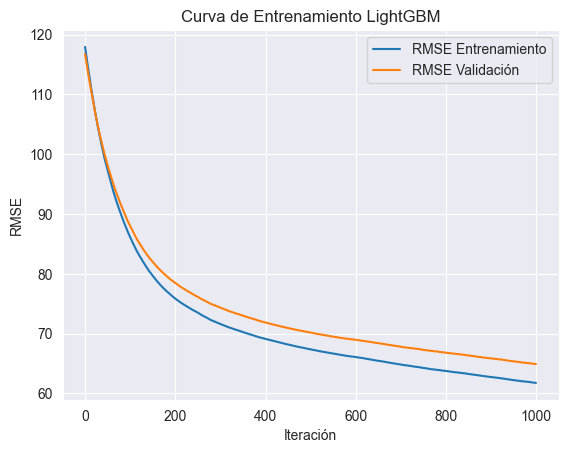

In [99]:
# 9. Graficar la curva de entrenamiento y validación
plt.plot(evals_result['training']['rmse'], label='RMSE Entrenamiento')
plt.plot(evals_result['valid_1']['rmse'],  label='RMSE Validación')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.title('Curva de Entrenamiento LightGBM')
plt.legend()
plt.show()

**6.2 Técnicas de validación cruzada**

In [100]:
# 2. Separar hold-out (20%)
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

In [101]:
# 6. Configurar modelo LightGBM
model = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

In [102]:
# 7. Validación K-Fold (k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    model, X_train_full, y_train_full,
    scoring='neg_root_mean_squared_error',
    cv=kf, n_jobs=-1
)
print("K-Fold CV (RMSE):", np.round(-cv_scores.mean(), 4),
      "±", np.round(cv_scores.std(), 4))

K-Fold CV (RMSE): 63.7653 ± 1.7301


In [103]:
# 8. Validación TimeSeriesSplit (forward chaining)
# permite evaluar el modelo tal como lo usarías “en vivo” sobre datos que llegan mes a mes, evitando mezclar pasado y futuro en cada fold y generando una métrica de error más realista para problemas de series temporales.
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores_ts = []
for train_idx, val_idx in tscv.split(X_train_full):
    X_tr, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rmse_scores_ts.append(root_mean_squared_error(y_val, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3610
[LightGBM] [Info] Number of data points in the train set: 13493, number of used features: 48
[LightGBM] [Info] Start training from score 121.233354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [104]:
print("TimeSeriesSplit CV (RMSE):",
      np.round(np.mean(rmse_scores_ts), 4),
      "±", np.round(np.std(rmse_scores_ts), 4))

TimeSeriesSplit CV (RMSE): 66.5915 ± 6.5411


In [105]:
# 9. Evaluación final en hold-out
model.fit(X_train_full, y_train_full)
y_hold_pred = model.predict(X_holdout)
rmse_hold = root_mean_squared_error(y_holdout, y_hold_pred)
mae_hold = mean_absolute_error(y_holdout, y_hold_pred)
r2_hold = r2_score(y_holdout, y_hold_pred)
print(f"Hold-out (20%) → RMSE: {rmse_hold:.4f}, MAE: {mae_hold:.4f}, R²: {r2_hold:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3869
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 48
[LightGBM] [Info] Start training from score 121.198275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

**6.3 Selección de hiperparámetros**

**Grid Search: búsqueda exhaustiva sobre combinaciones de max_depth**

In [106]:
# — Definir LGBMRegressor base —
base_model = LGBMRegressor(
    objective='regression',
    random_state=42
)

In [107]:
# — Parámetros a explorar —
param_grid = {
    'max_depth':    [5, 7, 9],
    'n_estimators': [500, 1000, 1500],
    'learning_rate':[0.01, 0.05, 0.1]
}

In [110]:
# — RMSE como scoring —
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [111]:
# — Configurar GridSearchCV —
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=kf,
    n_jobs=-1,
    verbose=1
)

In [112]:
# — Incluir early stopping vía fit_params —
fit_params = {
    'eval_set': [(X_train, y_train), (X_test, y_holdout)],
    'callbacks': [early_stopping(stopping_rounds=50)]
}

In [114]:
# — Ejecutar búsqueda —
grid.fit(X_train, y_train, **fit_params)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3869
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 48
[LightGBM] [Info] Start training from score 121.198275
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(objective='regression', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 7, 9],
                         'n_estimators': [500, 1000, 1500]},
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
             verbose=1)

In [115]:
# — Resultados —
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor RMSE (cv neg):", grid.best_score_)

Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1500}
Mejor RMSE (cv neg): -48.9462005280274


**Optimización Bayesiana con Optuna**

In [123]:
data = pd.merge(df, df_users[['household_ID','gender_label','age_category']], on='household_ID', how='left')
data['monthly_consumption_kwh'] = (
    data['monthly_consumption_kwh']
    .astype(str).str.replace(',', '.', regex=False)
    .pipe(pd.to_numeric, errors='coerce')
)

In [124]:
# Lista de columnas de tipo object
obj_cols = data.select_dtypes(include=['object']).columns.tolist()

# Codifica cada una con LabelEncoder
for col in obj_cols:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

In [125]:
data.dropna(subset=['monthly_consumption_kwh'], inplace=True)
data.columns = data.columns.str.replace(r'[^0-9A-Za-z_]+','_',regex=True).str.strip('_')
for col in ['gender_label','age_category','month']:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))
X = data.drop(columns=['household_ID','monthly_consumption_kwh'])
y = data['monthly_consumption_kwh']

In [128]:
def objective(trial):
    # split aleatorio interno para validación
    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=0.2, random_state=trial.number
    )

    # sugerir hiperparámetros con la API moderna
    params = {
        'learning_rate':   trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators':    trial.suggest_int('n_estimators', 500, 2000),
        'max_depth':       trial.suggest_int('max_depth', 4, 10),
        'subsample':       trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree':trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha':       trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda':      trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'random_state':    42
    }

    model = LGBMRegressor(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[early_stopping(stopping_rounds=50)]
    )

    preds = model.predict(X_val)
    return root_mean_squared_error(y_val, preds)

In [129]:
# — Lanzar estudio de Optuna —
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

[I 2025-05-26 12:44:57,090] A new study created in memory with name: no-name-9412b987-f4f8-4a61-8576-49e8cb1a132d


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4384
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 281
[LightGBM] [Info] Start training from score 121.333467
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1373]	valid_0's rmse: 70.5341	valid_0's l2: 4975.06


[I 2025-05-26 12:45:05,603] Trial 0 finished with value: 70.5341025213528 and parameters: {'learning_rate': 0.002652439445437251, 'n_estimators': 1373, 'max_depth': 8, 'subsample': 0.9898039810599009, 'colsample_bytree': 0.9183352003789862, 'reg_alpha': 2.373601798267761, 'reg_lambda': 0.0051428827942778515}. Best is trial 0 with value: 70.5341025213528.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4383
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 281
[LightGBM] [Info] Start training from score 121.282372
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-05-26 12:45:08,298] Trial 1 finished with value: 56.7464209324949 and parameters: {'learning_rate': 0.04695454779276603, 'n_estimators': 514, 'max_depth': 7, 'subsample': 0.9269228908611984, 'colsample_bytree': 0.5245534344814413, 'reg_alpha': 0.0021685140297602753, 'reg_lambda': 0.001984539437594971}. Best is trial 1 with value: 56.7464209324949.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4376
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 277
[LightGBM] [Info] Start training from score 121.293904
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:45:15,446] Trial 2 finished with value: 52.36660280726046 and parameters: {'learning_rate': 0.021023960544955124, 'n_estimators': 1511, 'max_depth': 8, 'subsample': 0.9404979009977944, 'colsample_bytree': 0.7300631249849585, 'reg_alpha': 0.010787004588475117, 'reg_lambda': 0.010885767388593159}. Best is trial 2 with value: 52.36660280726046.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4382
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 280
[LightGBM] [Info] Start training from score 121.415403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:45:18,863] Trial 3 finished with value: 64.10243076115803 and parameters: {'learning_rate': 0.04180294314602309, 'n_estimators': 911, 'max_depth': 4, 'subsample': 0.9470671775206101, 'colsample_bytree': 0.8324144118899615, 'reg_alpha': 0.15382594228952642, 'reg_lambda': 5.739609001229149}. Best is trial 2 with value: 52.36660280726046.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4381
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 280
[LightGBM] [Info] Start training from score 121.728772
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1099]	valid_0's rmse: 70.7923	valid_0's l2: 5011.55


[I 2025-05-26 12:45:24,916] Trial 4 finished with value: 70.7923084695469 and parameters: {'learning_rate': 0.0027865868734031785, 'n_estimators': 1099, 'max_depth': 9, 'subsample': 0.6728448180410045, 'colsample_bytree': 0.9254868594547925, 'reg_alpha': 1.604615054989543, 'reg_lambda': 0.0037645838761478103}. Best is trial 2 with value: 52.36660280726046.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4390
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 284
[LightGBM] [Info] Start training from score 121.311049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:45:28,362] Trial 5 finished with value: 82.57427461859801 and parameters: {'learning_rate': 0.003351305195839111, 'n_estimators': 503, 'max_depth': 5, 'subsample': 0.5133533111566971, 'colsample_bytree': 0.7215494770058244, 'reg_alpha': 5.394191708004496, 'reg_lambda': 0.0494878869295946}. Best is trial 2 with value: 52.36660280726046.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4386
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 121.196292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:45:30,723] Trial 6 finished with value: 65.9233651033874 and parameters: {'learning_rate': 0.04835762544851153, 'n_estimators': 540, 'max_depth': 5, 'subsample': 0.6777110757307283, 'colsample_bytree': 0.7248932447717914, 'reg_alpha': 0.09199993302936425, 'reg_lambda': 0.24901961994392474}. Best is trial 2 with value: 52.36660280726046.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4379
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 279
[LightGBM] [Info] Start training from score 121.150171
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:45:38,150] Trial 7 finished with value: 47.141306661750214 and parameters: {'learning_rate': 0.04400186641629128, 'n_estimators': 1662, 'max_depth': 7, 'subsample': 0.9734234479242956, 'colsample_bytree': 0.657864289893902, 'reg_alpha': 0.01573465286503356, 'reg_lambda': 0.0017028315676226196}. Best is trial 7 with value: 47.141306661750214.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4385
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 121.194924
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1659]	valid_0's rmse: 69.1931	valid_0's l2: 4787.68


[I 2025-05-26 12:45:47,819] Trial 8 finished with value: 69.19308826917573 and parameters: {'learning_rate': 0.00264139366268363, 'n_estimators': 1659, 'max_depth': 7, 'subsample': 0.9646238123291515, 'colsample_bytree': 0.512714319864965, 'reg_alpha': 0.004064410224913934, 'reg_lambda': 8.148313567874595}. Best is trial 7 with value: 47.141306661750214.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4387
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 120.849999
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:45:52,028] Trial 9 finished with value: 51.681681373010896 and parameters: {'learning_rate': 0.07381825075701166, 'n_estimators': 1003, 'max_depth': 7, 'subsample': 0.5919034993520862, 'colsample_bytree': 0.9427940639948744, 'reg_alpha': 0.02679747270065045, 'reg_lambda': 0.0034708352072323695}. Best is trial 7 with value: 47.141306661750214.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4386
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 121.539135
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1923]	valid_0's rmse: 58.1653	valid_0's l2: 3383.2


[I 2025-05-26 12:45:59,965] Trial 10 finished with value: 58.16525043773418 and parameters: {'learning_rate': 0.010610452603022204, 'n_estimators': 1923, 'max_depth': 10, 'subsample': 0.8026185857236774, 'colsample_bytree': 0.6068419804882498, 'reg_alpha': 0.2193381725990514, 'reg_lambda': 0.4372762277241971}. Best is trial 7 with value: 47.141306661750214.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4383
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 280
[LightGBM] [Info] Start training from score 121.600031
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:46:04,023] Trial 11 finished with value: 48.29873526890479 and parameters: {'learning_rate': 0.09588401394246983, 'n_estimators': 1033, 'max_depth': 6, 'subsample': 0.5056375404039491, 'colsample_bytree': 0.9849317065500319, 'reg_alpha': 0.025780365293808814, 'reg_lambda': 0.0011209980119109954}. Best is trial 7 with value: 47.141306661750214.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4383
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 281
[LightGBM] [Info] Start training from score 121.739542
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:46:10,721] Trial 12 finished with value: 48.49569305244035 and parameters: {'learning_rate': 0.09942643648093567, 'n_estimators': 1879, 'max_depth': 6, 'subsample': 0.8246689133781718, 'colsample_bytree': 0.6060646354634767, 'reg_alpha': 0.01690068090175846, 'reg_lambda': 0.0010245013676176912}. Best is trial 7 with value: 47.141306661750214.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4383
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 281
[LightGBM] [Info] Start training from score 121.534703
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:46:15,135] Trial 13 finished with value: 56.271367039977505 and parameters: {'learning_rate': 0.021960024145666283, 'n_estimators': 1291, 'max_depth': 6, 'subsample': 0.851319978731715, 'colsample_bytree': 0.8187636116699702, 'reg_alpha': 0.0011032375090931008, 'reg_lambda': 0.02587226809506031}. Best is trial 7 with value: 47.141306661750214.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4384
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 281
[LightGBM] [Info] Start training from score 121.595250
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[804]	valid_0's rmse: 89.2911	valid_0's l2: 7972.91


[I 2025-05-26 12:46:18,709] Trial 14 finished with value: 89.29112552562415 and parameters: {'learning_rate': 0.0010240000816259644, 'n_estimators': 804, 'max_depth': 6, 'subsample': 0.7313760816360506, 'colsample_bytree': 0.6420753771329978, 'reg_alpha': 0.05202500875927061, 'reg_lambda': 0.0010146285299229621}. Best is trial 7 with value: 47.141306661750214.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4386
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 121.676621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:46:22,786] Trial 15 finished with value: 63.49726107200892 and parameters: {'learning_rate': 0.019526337415212782, 'n_estimators': 1665, 'max_depth': 4, 'subsample': 0.5063085797252362, 'colsample_bytree': 0.9906792672935096, 'reg_alpha': 0.6053791530367602, 'reg_lambda': 0.018011506865073374}. Best is trial 7 with value: 47.141306661750214.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4387
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 121.318276
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:46:26,935] Trial 16 finished with value: 45.16186868392478 and parameters: {'learning_rate': 0.09382287478178139, 'n_estimators': 1165, 'max_depth': 8, 'subsample': 0.6022665415962956, 'colsample_bytree': 0.8029167746246189, 'reg_alpha': 0.0064593978369898285, 'reg_lambda': 1.175798848801269}. Best is trial 16 with value: 45.16186868392478.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4384
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 280
[LightGBM] [Info] Start training from score 121.104425
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1485]	valid_0's rmse: 49.7242	valid_0's l2: 2472.5


[I 2025-05-26 12:46:32,370] Trial 17 finished with value: 49.72423033505612 and parameters: {'learning_rate': 0.03137083448277735, 'n_estimators': 1485, 'max_depth': 9, 'subsample': 0.598876244681595, 'colsample_bytree': 0.8249046877867129, 'reg_alpha': 0.0064064621510233795, 'reg_lambda': 1.5787242405259532}. Best is trial 16 with value: 45.16186868392478.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4388
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 283
[LightGBM] [Info] Start training from score 121.107923
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1193]	valid_0's rmse: 59.6631	valid_0's l2: 3559.68


[I 2025-05-26 12:46:37,350] Trial 18 finished with value: 59.66308347613826 and parameters: {'learning_rate': 0.011568695529666374, 'n_estimators': 1193, 'max_depth': 8, 'subsample': 0.7433272253136912, 'colsample_bytree': 0.7836066181486935, 'reg_alpha': 0.003271080417344596, 'reg_lambda': 0.16336272985471037}. Best is trial 16 with value: 45.16186868392478.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4383
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 280
[LightGBM] [Info] Start training from score 121.392991
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1785]	valid_0's rmse: 47.3683	valid_0's l2: 2243.75


[I 2025-05-26 12:46:43,420] Trial 19 finished with value: 47.36827371675539 and parameters: {'learning_rate': 0.05885412545189901, 'n_estimators': 1785, 'max_depth': 9, 'subsample': 0.8961632811044509, 'colsample_bytree': 0.6708545306333695, 'reg_alpha': 0.0011905156108005775, 'reg_lambda': 0.8982493088201718}. Best is trial 16 with value: 45.16186868392478.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4383
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 281
[LightGBM] [Info] Start training from score 121.300097
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[726]	valid_0's rmse: 67.8293	valid_0's l2: 4600.81


[I 2025-05-26 12:46:47,013] Trial 20 finished with value: 67.8292822484227 and parameters: {'learning_rate': 0.004868463723505122, 'n_estimators': 726, 'max_depth': 8, 'subsample': 0.5966570336898682, 'colsample_bytree': 0.8744945061854529, 'reg_alpha': 0.008922425218825124, 'reg_lambda': 1.9941144402634852}. Best is trial 16 with value: 45.16186868392478.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4384
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 281
[LightGBM] [Info] Start training from score 121.531404
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1727]	valid_0's rmse: 44.1586	valid_0's l2: 1949.98


[I 2025-05-26 12:46:52,696] Trial 21 finished with value: 44.15856418138685 and parameters: {'learning_rate': 0.07109626091753733, 'n_estimators': 1727, 'max_depth': 10, 'subsample': 0.9150502500382316, 'colsample_bytree': 0.6811353263353198, 'reg_alpha': 0.0014599917697520834, 'reg_lambda': 0.9453764065662656}. Best is trial 21 with value: 44.15856418138685.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4386
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 121.656217
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1668]	valid_0's rmse: 43.9748	valid_0's l2: 1933.78


[I 2025-05-26 12:46:58,126] Trial 22 finished with value: 43.97480213559237 and parameters: {'learning_rate': 0.06660298293400521, 'n_estimators': 1668, 'max_depth': 10, 'subsample': 0.8728239994306275, 'colsample_bytree': 0.6757287125849495, 'reg_alpha': 0.0020307479147136254, 'reg_lambda': 0.5899770842604579}. Best is trial 22 with value: 43.97480213559237.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4378
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 278
[LightGBM] [Info] Start training from score 121.292773
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1989]	valid_0's rmse: 45.1858	valid_0's l2: 2041.76


[I 2025-05-26 12:47:04,697] Trial 23 finished with value: 45.185792357451014 and parameters: {'learning_rate': 0.07484447466694719, 'n_estimators': 1989, 'max_depth': 10, 'subsample': 0.8786055157131746, 'colsample_bytree': 0.6901968748284624, 'reg_alpha': 0.0022865864050086522, 'reg_lambda': 0.6776900168687472}. Best is trial 22 with value: 43.97480213559237.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4386
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 281
[LightGBM] [Info] Start training from score 121.547498
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1487]	valid_0's rmse: 49.9411	valid_0's l2: 2494.11


[I 2025-05-26 12:47:10,214] Trial 24 finished with value: 49.94108078753362 and parameters: {'learning_rate': 0.02618368622893371, 'n_estimators': 1487, 'max_depth': 10, 'subsample': 0.7899366159552623, 'colsample_bytree': 0.783449351894557, 'reg_alpha': 0.0010587375232277453, 'reg_lambda': 3.366639707469087}. Best is trial 22 with value: 43.97480213559237.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4390
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 283
[LightGBM] [Info] Start training from score 121.584714
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1801]	valid_0's rmse: 46.4446	valid_0's l2: 2157.1


[I 2025-05-26 12:47:17,403] Trial 25 finished with value: 46.444569653777435 and parameters: {'learning_rate': 0.06739824631415418, 'n_estimators': 1801, 'max_depth': 9, 'subsample': 0.8919424462183966, 'colsample_bytree': 0.5702894737402192, 'reg_alpha': 0.0037359271760453875, 'reg_lambda': 0.08044392280462198}. Best is trial 22 with value: 43.97480213559237.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4385
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 121.777499
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1345]	valid_0's rmse: 54.9763	valid_0's l2: 3022.39


[I 2025-05-26 12:47:23,053] Trial 26 finished with value: 54.976278383988706 and parameters: {'learning_rate': 0.014931471959484204, 'n_estimators': 1345, 'max_depth': 10, 'subsample': 0.6969704466090686, 'colsample_bytree': 0.7675147974864658, 'reg_alpha': 0.005900815876492647, 'reg_lambda': 0.3222912504076375}. Best is trial 22 with value: 43.97480213559237.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4383
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 280
[LightGBM] [Info] Start training from score 121.333740
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1195]	valid_0's rmse: 48.7437	valid_0's l2: 2375.95


[I 2025-05-26 12:47:27,589] Trial 27 finished with value: 48.743681571003926 and parameters: {'learning_rate': 0.031820028745986245, 'n_estimators': 1195, 'max_depth': 9, 'subsample': 0.844810935087114, 'colsample_bytree': 0.7028477605047289, 'reg_alpha': 0.0018689107636532096, 'reg_lambda': 1.3718116974070866}. Best is trial 22 with value: 43.97480213559237.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4386
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 121.469582
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1558]	valid_0's rmse: 47.7769	valid_0's l2: 2282.63


[I 2025-05-26 12:47:33,459] Trial 28 finished with value: 47.77687377648974 and parameters: {'learning_rate': 0.03556408099268224, 'n_estimators': 1559, 'max_depth': 10, 'subsample': 0.7706794400596046, 'colsample_bytree': 0.6238023635242265, 'reg_alpha': 0.04929768508753936, 'reg_lambda': 4.144952204865711}. Best is trial 22 with value: 43.97480213559237.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4381
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 280
[LightGBM] [Info] Start training from score 121.680358
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1378]	valid_0's rmse: 44.9243	valid_0's l2: 2018.19


[I 2025-05-26 12:47:38,219] Trial 29 finished with value: 44.92427340951486 and parameters: {'learning_rate': 0.05714742942482644, 'n_estimators': 1378, 'max_depth': 9, 'subsample': 0.636107603688552, 'colsample_bytree': 0.8637272066899624, 'reg_alpha': 0.004517329418831188, 'reg_lambda': 0.5910281580935783}. Best is trial 22 with value: 43.97480213559237.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4386
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 120.993169
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1404]	valid_0's rmse: 67.1399	valid_0's l2: 4507.76


[I 2025-05-26 12:47:44,728] Trial 30 finished with value: 67.13988874635481 and parameters: {'learning_rate': 0.00767443803562508, 'n_estimators': 1404, 'max_depth': 10, 'subsample': 0.6273595414813103, 'colsample_bytree': 0.8629107000655482, 'reg_alpha': 0.002047951826101547, 'reg_lambda': 0.5153031696090362}. Best is trial 22 with value: 43.97480213559237.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4390
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 284
[LightGBM] [Info] Start training from score 121.608504
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1744]	valid_0's rmse: 46.0764	valid_0's l2: 2123.04


[I 2025-05-26 12:47:50,726] Trial 31 finished with value: 46.076418561065246 and parameters: {'learning_rate': 0.06129487908466113, 'n_estimators': 1745, 'max_depth': 9, 'subsample': 0.5634458376794034, 'colsample_bytree': 0.8916544016481921, 'reg_alpha': 0.004866197695632215, 'reg_lambda': 0.1692492777095684}. Best is trial 22 with value: 43.97480213559237.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4387
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 283
[LightGBM] [Info] Start training from score 121.302481
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:47:55,450] Trial 32 finished with value: 44.84003765455295 and parameters: {'learning_rate': 0.0996578634653747, 'n_estimators': 1355, 'max_depth': 8, 'subsample': 0.9924136237097612, 'colsample_bytree': 0.7535376994443714, 'reg_alpha': 0.002070369915467327, 'reg_lambda': 0.9060804397103801}. Best is trial 22 with value: 43.97480213559237.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4386
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 121.323061
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1410]	valid_0's rmse: 42.2093	valid_0's l2: 1781.63


[I 2025-05-26 12:48:00,441] Trial 33 finished with value: 42.20930291157292 and parameters: {'learning_rate': 0.05378086711415468, 'n_estimators': 1410, 'max_depth': 9, 'subsample': 0.9987946024851285, 'colsample_bytree': 0.7509727040953247, 'reg_alpha': 0.002268471491652277, 'reg_lambda': 2.1226228926235415}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4382
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 280
[LightGBM] [Info] Start training from score 121.089303
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:48:05,870] Trial 34 finished with value: 47.322463852873 and parameters: {'learning_rate': 0.046578402202859255, 'n_estimators': 1577, 'max_depth': 8, 'subsample': 0.9912520123349366, 'colsample_bytree': 0.7503206037065695, 'reg_alpha': 0.002036911831313592, 'reg_lambda': 3.4599349477081582}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4381
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 280
[LightGBM] [Info] Start training from score 121.503761
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1439]	valid_0's rmse: 47.9031	valid_0's l2: 2294.71


[I 2025-05-26 12:48:11,641] Trial 35 finished with value: 47.90311524161634 and parameters: {'learning_rate': 0.07743878954417378, 'n_estimators': 1442, 'max_depth': 10, 'subsample': 0.9215529090809516, 'colsample_bytree': 0.5747770359790978, 'reg_alpha': 0.0016764753594346437, 'reg_lambda': 2.353790387473643}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4387
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 121.301840
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did n

[I 2025-05-26 12:48:17,404] Trial 36 finished with value: 47.36731293775725 and parameters: {'learning_rate': 0.03614849889247894, 'n_estimators': 1583, 'max_depth': 9, 'subsample': 0.9320578033526614, 'colsample_bytree': 0.6990502371287401, 'reg_alpha': 0.010515064720877702, 'reg_lambda': 8.90231853651199}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4386
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 283
[LightGBM] [Info] Start training from score 121.189052
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:48:22,181] Trial 37 finished with value: 45.53027326402597 and parameters: {'learning_rate': 0.053713780632174433, 'n_estimators': 1303, 'max_depth': 8, 'subsample': 0.9961251867947915, 'colsample_bytree': 0.7357006272390197, 'reg_alpha': 0.00311427176959278, 'reg_lambda': 0.8810255379229522}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4385
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 281
[LightGBM] [Info] Start training from score 121.449824
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1717]	valid_0's rmse: 44.1652	valid_0's l2: 1950.57


[I 2025-05-26 12:48:27,929] Trial 38 finished with value: 44.16521137796314 and parameters: {'learning_rate': 0.0836468390512818, 'n_estimators': 1717, 'max_depth': 9, 'subsample': 0.9587543454226976, 'colsample_bytree': 0.7638478998796133, 'reg_alpha': 0.3041686578955699, 'reg_lambda': 0.21788596991203435}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4381
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 279
[LightGBM] [Info] Start training from score 121.292042
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1727]	valid_0's rmse: 48.7314	valid_0's l2: 2374.75


[I 2025-05-26 12:48:34,437] Trial 39 finished with value: 48.73137221370069 and parameters: {'learning_rate': 0.024970264814746183, 'n_estimators': 1727, 'max_depth': 10, 'subsample': 0.9580638445057534, 'colsample_bytree': 0.6750980745569441, 'reg_alpha': 0.4006821694741032, 'reg_lambda': 0.08012572309201443}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4387
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 121.224293
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1870]	valid_0's rmse: 46.6	valid_0's l2: 2171.56


[I 2025-05-26 12:48:40,732] Trial 40 finished with value: 46.600021198721855 and parameters: {'learning_rate': 0.04320399220589461, 'n_estimators': 1870, 'max_depth': 9, 'subsample': 0.9078775155240185, 'colsample_bytree': 0.7164095563117218, 'reg_alpha': 1.5096757641661211, 'reg_lambda': 0.2589558264637439}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4389
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 283
[LightGBM] [Info] Start training from score 121.022463
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1649]	valid_0's rmse: 46.4365	valid_0's l2: 2156.35


[I 2025-05-26 12:48:46,489] Trial 41 finished with value: 46.43654849470222 and parameters: {'learning_rate': 0.08236743942096429, 'n_estimators': 1649, 'max_depth': 9, 'subsample': 0.9454600575573262, 'colsample_bytree': 0.7476915492546743, 'reg_alpha': 0.12398277878982318, 'reg_lambda': 0.1390629582941734}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4387
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 283
[LightGBM] [Info] Start training from score 121.198275
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1545]	valid_0's rmse: 46.3377	valid_0's l2: 2147.18


[I 2025-05-26 12:48:51,923] Trial 42 finished with value: 46.33769453027631 and parameters: {'learning_rate': 0.06298320353608979, 'n_estimators': 1545, 'max_depth': 10, 'subsample': 0.9723256180005989, 'colsample_bytree': 0.6499105332882821, 'reg_alpha': 0.5903054531972398, 'reg_lambda': 0.3601323882691888}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4377
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 278
[LightGBM] [Info] Start training from score 121.081962
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2025-05-26 12:48:57,766] Trial 43 finished with value: 46.23799066415394 and parameters: {'learning_rate': 0.08396573829481395, 'n_estimators': 1710, 'max_depth': 8, 'subsample': 0.9998608070355184, 'colsample_bytree': 0.7659089879417628, 'reg_alpha': 1.267601650400646, 'reg_lambda': 0.8653635164235951}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4380
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 279
[LightGBM] [Info] Start training from score 121.383491
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1633]	valid_0's rmse: 42.7147	valid_0's l2: 1824.54


[I 2025-05-26 12:49:03,467] Trial 44 finished with value: 42.71466413811805 and parameters: {'learning_rate': 0.07090321900910063, 'n_estimators': 1633, 'max_depth': 9, 'subsample': 0.9253346440562656, 'colsample_bytree': 0.8005952407358957, 'reg_alpha': 0.20656368198671085, 'reg_lambda': 1.988254456791358}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4380
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 279
[LightGBM] [Info] Start training from score 121.172657
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1839]	valid_0's rmse: 44.415	valid_0's l2: 1972.69


[I 2025-05-26 12:49:10,091] Trial 45 finished with value: 44.414966573639106 and parameters: {'learning_rate': 0.048282257555545195, 'n_estimators': 1839, 'max_depth': 10, 'subsample': 0.8674714044571525, 'colsample_bytree': 0.7961406579364201, 'reg_alpha': 0.2375885370271184, 'reg_lambda': 6.212249004133751}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4386
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 282
[LightGBM] [Info] Start training from score 121.113737
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1948]	valid_0's rmse: 45.7947	valid_0's l2: 2097.16


[I 2025-05-26 12:49:17,194] Trial 46 finished with value: 45.79473727831102 and parameters: {'learning_rate': 0.04104772419539142, 'n_estimators': 1948, 'max_depth': 9, 'subsample': 0.9189547346278296, 'colsample_bytree': 0.8366372124355783, 'reg_alpha': 0.06982367988328818, 'reg_lambda': 2.67263074408114}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4393
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 285
[LightGBM] [Info] Start training from score 121.178108
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1635]	valid_0's rmse: 45.0517	valid_0's l2: 2029.65


[I 2025-05-26 12:49:23,138] Trial 47 finished with value: 45.051673864668274 and parameters: {'learning_rate': 0.07075592773235664, 'n_estimators': 1635, 'max_depth': 10, 'subsample': 0.9433211927144765, 'colsample_bytree': 0.7201768962439405, 'reg_alpha': 0.2025896872230733, 'reg_lambda': 4.709680757469417}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4384
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 281
[LightGBM] [Info] Start training from score 121.009082
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1614]	valid_0's rmse: 80.8792	valid_0's l2: 6541.44


[I 2025-05-26 12:49:30,195] Trial 48 finished with value: 80.87916320322246 and parameters: {'learning_rate': 0.0010040305191507473, 'n_estimators': 1614, 'max_depth': 9, 'subsample': 0.8254259219426352, 'colsample_bytree': 0.6895941117242483, 'reg_alpha': 7.744377240997837, 'reg_lambda': 0.053585933655799584}. Best is trial 33 with value: 42.20930291157292.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4381
[LightGBM] [Info] Number of data points in the train set: 80948, number of used features: 279
[LightGBM] [Info] Start training from score 121.327506
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1781]	valid_0's rmse: 74.688	valid_0's l2: 5578.3


[I 2025-05-26 12:49:38,607] Trial 49 finished with value: 74.6879960015439 and parameters: {'learning_rate': 0.0016161535330689338, 'n_estimators': 1781, 'max_depth': 10, 'subsample': 0.9671780151759846, 'colsample_bytree': 0.6316130037317081, 'reg_alpha': 0.43170803821674864, 'reg_lambda': 1.8071401271108467}. Best is trial 33 with value: 42.20930291157292.


In [130]:
print("Mejores parámetros:", study.best_params)
print("Mejor RMSE:", study.best_value)

Mejores parámetros: {'learning_rate': 0.05378086711415468, 'n_estimators': 1410, 'max_depth': 9, 'subsample': 0.9987946024851285, 'colsample_bytree': 0.7509727040953247, 'reg_alpha': 0.002268471491652277, 'reg_lambda': 2.1226228926235415}
Mejor RMSE: 42.20930291157292
